# **Aprendizaje Automático para Machine Learning**

##Support Vector Machine - Reconocimiento de imágenes##

###Andrea Azábal Lamoso###

5 de julio de 2021

---

#*Support Vector Machine*

El objetivo de entrenar una SVM es construir un modelo que prediga una clase de una nueva muestra dado un conjunto de ejemplos de entrenamiento. Así, se separan las clases a $m$ espacios lo más amplios posibles mediante un hiperplano de separación definido como el vector entre los $m$ puntos de las $m$ clases más cercanos al que se llama *vector soporte*. 

Estos algoritmos son válidos incluso cuando la frontera entre las clases no es lineal o, lo que es lo mismo, los datos no son linealmente separables. La razón es que, mediante la introducción de *kernels*,  las SVM realizan una transformación no lineal del espacio de entrada de manera que pueda aplicarse un clasificador de vectores soporte por margen máximo. Los *kernels* más habituales son el lineal, el polinómico, el sigmoide y el radial (Gaussiano).

De esta manera, se permiten una serie de *violaciones* al margen o hiperplano seleccionados, las cuales se determinan mediante el *parámetro de ajuste/afinación $C$* (**tuning**). 

En el algoritmo que vamos a aplicar, `SVC()` -*Support Vector Classifier*-, el hiperparámetro $C$ asigna una penalización a los puntos clasificados erróneamente, es decir, en el lado incorrecto del hiperplano. 

Si la penalización es baja, es decir, para valores bajos de $C$,  se tienen márgenes anchos que permiten mayores violaciones, incrementando el sesgo pero reduciendo la varianza. Esto conlleva a la generación de un modelo excesivamente simplista, que puede no ajustarse lo suficiente al *dataset* de entrenamiento (*underfitting*). 

Por el contrario, si $C$ es grande, las penalizaciones lo son también y existe un mayor ajuste al conjunto de datos, pudiendo incluso darse *overfitting*. En este caso se tienen márgenes estrechos que raramente son violados, lo que reduce el sesgo pero incrementa la varianza.

El objetivo de esta entrega es implementar una SVM para dos *datasets*:

- MNIST
- Fashion-MNIST

Para cada uno de ellos se implementará tanto un *kernel* lineal como uno Gaussiano con el objetivo de obtener la mejor especificación del modelo que arroje las predicciones más precisas.


# Preparación del entorno

Importamos los paquetes necesarios:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import re
import matplotlib.pyplot as plt

In [ ]:
from time import time
import datetime
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf

# *Dataset MNIST*

El primer conjunto de datos está compuesto por dígitos de MNIST (Modified-NIST, del Instituto Nacional de Estándares y Tecnología de EEUU). Disponemos de la siguiente información:

- X_train: array de 60.000x28x28, donde cada celda representa un pixel de las diferentes imágenes. Es decir, que tenemos un set de entrenamiento de 60.000 dígitos de 28x28 píxeles (784 pixels) cada uno. Los valores de cada celda representan el código RGB en escala de grises de los diferentes píxeles (0 es blanco y 255 es negro). 
- Y_train: array de 60.000 filas, donde cada fila tiene el valor entero del dígito de la imagen. 
- X_test: array de 10.000x28x28, donde cada celda representa un pixel de las diferentes imágenes. Es decir, que tenemos un set de test de 10.000 dígitos de 28x28 píxeles (784 pixels) cada uno. Los valores de cada celda representan el código RGB en escala de grises de los diferentes píxeles (0 es blanco y 255 es negro). 
- Y_test: array de 10.000 filas, donde cada fila tiene el valor entero del dígito de la imagen.




Importamos el conjunto de datos desde *TensorFlow*:

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Nos valemos de la función `reshape()` para almacenar una única línea (de 28x28=784 columnas) por cada imagen:

In [ ]:
x_train = x_train.reshape(60000,-1)
x_test = x_test.reshape(10000,-1)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


A continuación se ha representado una muestra de las categorías contenidas en el *dataset* con sus imágenes correspondientes:

In [ ]:
y_u=pd.DataFrame(y_train).drop_duplicates()
X_u=x_train[y_u[0].sort_values().index]

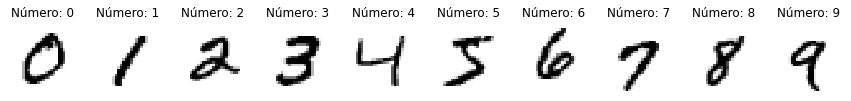

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, label in zip(axes, X_u, y_u[0].sort_values()):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Número: %i' % label)

##Modelización

A lo largo de la tarea, con el objetivo de obtener tiempos computacionales razonables, se va a seleccionar un subconjunto de 20.000 dígitos para el entrenamiento del modelo y 10.000 para la evaluación del mismo.



In [ ]:
n_train = 20000 # digitos a usar en entrenamiento
x_train1=x_train[0:n_train]
y_train1=y_train[0:n_train]
n_test = 10000 # digitos a usar en testing
x_test1=x_test[0:n_test]
y_test1=y_test[0:n_test]

Podemos comprobar qué porcentaje del total supone cada dígito:

In [ ]:
pd.Series(y_train1).value_counts()/20000

1    0.11405
7    0.10465
3    0.10380
9    0.10070
0    0.09970
6    0.09855
4    0.09725
2    0.09645
8    0.09610
5    0.08875
dtype: float64

Vemos que el número más abundante es el 1 en este *dataset* (11% de las observaciones), mientras que el menos repetido es el 5 (9%). Es un *dataset* bastante balanceado.

Finalmente, como sabemos que cada píxel puede tomar valores entre 0 y 255, vamos a transformar los datos a tipo *float* y normalizar los valores dividiendo por su valor máximo.

In [ ]:
x_train1.max()

255

In [ ]:
# convert from integers to floats
x_train1 = x_train1.astype('float32')
x_test1 = x_test1.astype('float32')
# normalize to range 0-1
x_train1 = x_train1 / 255.0
x_test1 = x_test1 / 255.0

Comprobamos que el nuevo máximo es 1:

In [ ]:
x_train1.max()

1.0

###*Kernel* lineal

A la hora de realizar el entrenamiento del modelo, vamos a comenzar por parametrizar un *kernel* lineal. Además, se van a probar diferentes valores del parámetro $C$ introducido previamente. Como ya se ha argumentado, este parámetro es inversamente proporcional al número de violaciones del margen permitidas o, lo que es lo mismo, el número de observaciones que pueden ser clasificadas erróneamente. El resto de parámetros tomarán sus valores por defecto.



In [ ]:
minAcc = 100
maxAcc = 0
rapidoAcc = 0
lentoAcc = 0
mejorTime = 0
peorTime = 0
minTime = 1000000000
maxTime = 0

mejorModelo = SVC()
peorModelo = SVC()
rapidoModelo = SVC()
lentoModelo = SVC()

kernel = "linear"

for c in (1, 10, 100, 1000):
  print("Kernel lineal con C=", c)
  
  timeIni = time()
  modelo = SVC(kernel = kernel, C=c).fit(x_train1,y_train1)
  print(modelo)
  timeEnd = time()
  timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

  acc_1 = modelo.score(x_train1, y_train1)
  acc_2 = modelo.score(x_test1, y_test1)
  print("Precisión train (accuracy): ", acc_1)
  print("Precisión test (accuracy): ", acc_2)
  print("Tiempo entrenamiento: ", timeDiff)

  predicciones = modelo.predict(x_test1)
  print("Matriz de confusión:")
  print(confusion_matrix(y_test1, predicciones))
  print(classification_report(y_test1, predicciones))
  print("---------------------------------------")
  print()

  if (maxAcc < acc_2):
      maxAcc = acc_2
      mejorTime = timeEnd-timeIni
      mejorModelo = modelo

  if (minAcc > acc_2):
      minAcc = acc_2
      peorTime = timeEnd-timeIni
      peorModelo = modelo

  if (timeEnd-timeIni > maxTime):
      lentoAcc = acc_2
      maxTime = timeEnd-timeIni
      lentoModelo = modelo

  if (timeEnd-timeIni < minTime):
      rapidoAcc = acc_2
      minTime = timeEnd-timeIni
      rapidoModelo = modelo

Kernel lineal con C= 1
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Precisión train (accuracy):  0.9891
Precisión test (accuracy):  0.9257
Tiempo entrenamiento:  01:08:259303
Matriz de confusión:
[[ 951    0    4    3    0   11    8    1    1    1]
 [   0 1118    3    3    1    2    1    1    6    0]
 [   8    7  952   16    4    3    9   12   17    4]
 [   4    4   21  924    1   20    0   11   20    5]
 [   0    0    8    2  931    1    9    6    2   23]
 [  14    5    6   41    7  780   10    2   24    3]
 [   9    3   14    0    7   13  911    1    0    0]
 [   2    9   22   13   17    0    0  943    0   22]
 [   9    7   16   31   10   33    8    6  846    8]
 [  11    8    2   14   35    4    1   26    7  901]]
              precision    recall  f1-score   support

           0

Vemos que, según va aumentando $C$, la precisión sobre el subconjunto de entrenamiento va aumentando ligeramente, como cabría esperar pues las penalizaciones asignadas a cada punto erróneo van aumentando y, por tanto, se están permitiendo menos violaciones del margen. Si únicamente nos fijásemos en este parámetro, entonces elegiríamos el modelo con $C=100$ pues es el que tiene un *accuracy* del 100%. Sin embargo, estaríamos llegando a una conclusión errónea, pues hay que asegurarse de que no estamos generando *overfitting*.

Así, vemos que sucede lo contrario con la precisión sobre el subconjunto de *test*, pues esta va disminuyendo desde un 92.6% hasta un 91.4% según sube el valor de $C$. La diferencia no es muy significativa, pero si nos fijamos en los tiempos de ejecución, vemos que hay 3s de diferencia entre el modelo más rápido y el más lento, siendo $C=1$ el mejor de entre los 4 planteados tanto en precisión como en tiempos de ejecución. Para valores $C>1$ estaríamos generando cierto *overfitting*, pues el algoritmo pierde capacidad de generalización de las predicciones sobre nuevos *datasets*.

Por tanto, concluimos que **para el *kernel* lineal, el modelo óptimo es aquel con $C=1$.**

Por último, si nos fijamos en las matrices de confusión, vemos que son muy similares entre los distintos modelos, puesto que, aunque sí que cambian los resultados del *F1-Score* por categoría de un modelo a otro, las precisiones de cada clase son siempre superiores al 85%.

### *Kernel* radial o *Gaussiano*

En esta segunda parametrización, vamos a proceder de manera idéntica pero cambiando el *kernel* lineal por el *Gaussiano* `kernel='rbf'`. El resto de parámetros se dejan por defecto con el fin de obtener unos tiempos de computación razonables.

In [ ]:
kernel = "rbf"

for c in (1, 10, 100, 1000):
    print("Kernel Gaussiano con C ", c)
    timeIni = time()
    modelo = SVC(kernel = kernel , C=c).fit(x_train1,y_train1)
    print(modelo)
    timeEnd = time()
    timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

    acc_1 = modelo.score(x_train1, y_train1)
    acc_2 = modelo.score(x_test1, y_test1)
    print("Precisión train (accuracy): ", acc_1)
    print("Precisión test (accuracy): ", acc_2)
    print("Tiempo entrenamiento: ", timeDiff)

    predicciones = modelo.predict(x_test1)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test1, predicciones))
    print(classification_report(y_test1, predicciones))
    print("---------------------------------------")
    print()

    if (maxAcc < acc_2):
      maxAcc = acc_2
      mejorTime = timeEnd-timeIni
      mejorModelo = modelo

    if (minAcc > acc_2):
      minAcc = acc_2
      peorTime = timeEnd-timeIni
      peorModelo = modelo

    if (timeEnd-timeIni > maxTime):
      lentoAcc = acc_2
      maxTime = timeEnd-timeIni
      lentoModelo = modelo

    if (timeEnd-timeIni < minTime):
      rapidoAcc = acc_2
      minTime = timeEnd-timeIni
      rapidoModelo = modelo

Kernel Gaussiano con C  1
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Precisión train (accuracy):  0.98765
Precisión test (accuracy):  0.9695
Tiempo entrenamiento:  01:44:874406
Matriz de confusión:
[[ 969    0    1    0    0    3    4    1    2    0]
 [   0 1124    3    2    0    2    1    1    2    0]
 [   5    0 1001    1    4    0    2   10    9    0]
 [   0    0    5  982    0    5    0    9    7    2]
 [   1    0    3    0  955    0    6    1    2   14]
 [   5    1    0   14    1  856    6    1    6    2]
 [   8    3    0    1    2    5  937    0    2    0]
 [   0   11   16    7    2    0    0  980    0   12]
 [   4    0    3   12    4    8    2    4  935    2]
 [   5    6    2    8   17    1    0    8    6  956]]
              precision    recall  f1-score   support

           

Como se puede observar, con este nuevo *kernel*, tanto la precisión global de cada modelo sobre el subconjunto de *testing* como sus respectivos tiempos de computación han aumentado con respecto a los modelizados previos. 

Si nos fijamos en la precisión sobre el subconjunto de entrenamiento, vemos que de nuevo esta va aumentando con $C$ por las razones ya argumentadas. Por tanto, para seleccionar el modelo más óptimo y evitar tanto el *overfitting* como el *underfitting*, vamos a fijarnos en la *accuracy* del subconjunto de prueba.

Así, contrariamente a los modelizados realizados para el *kernel* lineal, en este caso el hecho de aumentar el parámetro $C$ desde 1 hasta 10 hace que mejore la precisión y se reduzca el tiempo de ejecución. Para los valores $C=100, 1000$ se obtienen precisiones ligeramente inferiores y tiempos muy similares, teniéndose el máximo de la *accuracy* (*test*) para $C=10$. 

Esto se traduce en que, para valores $C<10$, tenemos *underfitting* pues tanto la precisión sobre el subconjunto de entrenamiento como la precisión sobre el subconjunto de *test* son relativamente bajas (en comparación con el resto de los resultados de las parametrizaciones planteadas). En este caso, se están permitiendo demasiadas violaciones al margen, lo cual se traduce en un modelo demasiado simple que no se ajusta lo suficiente al conjunto de datos.

Para $C>10$, se tiene un alto valor de la *accuracy* del *set* de entrenamiento pero la del *set* de *test* no aumenta, sino que disminuye muy levemente. Estamos, por tanto, ante la presencia de un ligero sobreajuste para $C>10$, pues no se permiten los suficientes errores de clasificación.

Por tanto, concluimos que **para el *kernel* radial o *Gaussiano*, el valor óptimo del hiperparámetro es $C=10$.**

Respecto a las matrices de confusión resultantes, vemos que en todas ellas se supera el 95% tanto de *precision* como de *recall* en todas las categorías, valores muy superiores a los alcanzados con el *kernel* lineal.

##Comparativa entre modelos

De entre todos los modelos propuestos para este *dataset*, se procede a realizar un resumen de los resultados obtenidos:

In [ ]:
print("El mejor modelo es: ", mejorModelo.kernel)
print(mejorModelo)
print("Accuracy: ", maxAcc)
print("Tiempo: ", datetime.datetime.fromtimestamp(mejorTime).strftime("%M:%S:%f"))
print()

print("El peor modelo es: ", peorModelo.kernel)
print(peorModelo)
print("Accuracy: ", minAcc)
print("Tiempo: ", datetime.datetime.fromtimestamp(peorTime).strftime("%M:%S:%f"))
print()

print("El modelo más rápido es: ", rapidoModelo.kernel)
print(rapidoModelo)
print("Accuracy: ", rapidoAcc)
print("Tiempo: ", datetime.datetime.fromtimestamp(minTime).strftime("%M:%S:%f"))
print()

print("El modelo más lento es: ", lentoModelo.kernel)
print(lentoModelo)
print("Accuracy: ", lentoAcc)
print("Tiempo: ", datetime.datetime.fromtimestamp(maxTime).strftime("%M:%S:%f"))

El mejor modelo es:  rbf
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:  0.9767
Tiempo:  01:35:708721

El peor modelo es:  linear
SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:  0.9143
Tiempo:  01:10:730448

El modelo más rápido es:  linear
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:  0.9257
Tiempo:  01:08:259303

El modelo más lento es:  rbf
SVC(C=1, b

En la siguiente tabla se recoge una comparación de todos los modelos ejecutados hasta ahora:

|$C$|*Accuracy* lineal (%)|*Accuracy Gaussiano* (%)|Tiempo lineal|Tiempo *Gaussiano*|
|:-----:|:--------:|:-------:|:---------:|:---------:|
|  $1$  |  92.57   |   96.95    | 1min 08s  |1min 44s   | 
|  $10$ |  91.62   |   97.67    | 1min 10s  |1min 35s   |
| $100$ |  91.43   |   97.64    | 1min 10s  |1min 36s   |
|$1000$ |  91.43   |   97.64    | 1min 11s  |1min 36s   |



Se concluye, por tanto, que el modelo más preciso es el *Gaussiano* con $C=10$, aunque, como ya habíamos visto, los resultados para $C=100$ o $C=1000$ son muy similares (con un ligero sobreajuste) y ligeramente más rápidos, por lo que también serían una buena especificación a elegir.

Por otra parte, el modelo más rápido es el lineal con $C=1$, siendo su precisión muy inferior en comparación al *kernel* radial (4.5% menos).

Concluimos, por tanto, que el *kernel* óptimo dependerá de nuestras necesidades particulares. Si necesitamos un modelo muy preciso, entonces seleccionaremos el *Gaussiano*. Si, en cambio, podemos permitirnos una *accuracy* inferior o buscamos un modelo que no consuma tantos recursos computacionales, entonces bastará con seleccionar el *kernel* lineal.



##Evaluación del modelo

Si generamos el modelo más preciso con `kernel='rbf'` y `C=10`:

In [ ]:
modelo_rbf_10 = SVC(kernel = "rbf" , C=10).fit(x_train1,y_train1)
acc_rbf_10 = modelo_rbf_10.score(x_test1, y_test1)
predicciones_rbf_10 = modelo_rbf_10.predict(x_test1)

- **Matriz de confusión**

A continuación generamos su matriz de confusión sobre el subconjunto de *test*:

Confusion matrix:



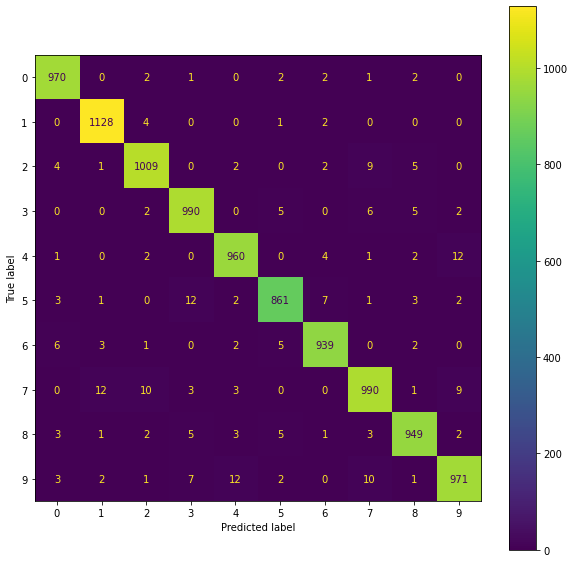

In [ ]:
from sklearn import metrics
print(f"Confusion matrix:\n")
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(modelo_rbf_10, x_test1, y_test1, cmap=plt.cm.viridis, ax=ax, values_format = '.0f')
plt.show()

Así, comprobamos que el algoritmo está funcionando bastante bien pues la mayoría de las observaciones están en la diagonal, es decir, ha predicho el valor correcto (verdaderos positivos). Los valores fuera de la diagonal indican falsos positivos si se encuentran a lo largo de la columna de la etiqueta predicha y falsos negativos si se encuentran a lo largo de la fila del valor real.

Si, por ejemplo, nos fijamos en el dígito 1, podemos obtener su *precision* y *recall* de la siguiente forma:

$$ Precision_1 =  \frac{TP}{TP+FP} = \frac{1128}{1128+1+1+3+12+1+2}= 0.9826$$ 

$$ Recall_1 =  \frac{TP}{TP+FN}=\frac{1128}{1128+4+1+2}=0.9938$$ 

Por tanto, para esta clase no se están generando muchos falsos negativos pues el *recall* es muy alto pero sí que se están dando algunos falsos positivos (*precision* ligeramente más bajo aunque sigue siendo muy bueno).

-  ***Precision* y *recall***

Si obtenemos estos indicadores para todas las clases (gracias a `classification_report()`):

In [ ]:
print(f"Classification report for classifier {modelo_rbf_10}:\n"
      f"{metrics.classification_report(y_test1, predicciones_rbf_10)}\n")

Classification report for classifier SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted 

El dígito que mejor se está clasificando por el algoritmo (atendiendo al *F1-Score*) es el 1 (99%). 

Por el contrario, los números 5, 7 y 9 son los que peores resultados están dando. De hecho, si nos fijamos en la matriz de confusión representada, vemos que el número 5 se está clasificando erróneamente como un 3 en la mayoría de falsos negativos, lo cual hace que disminuya el *recall*.

Por otra parte, en el caso del número 9, este se está clasificando mayoritariamente como un 4 o un 7 en las predicciones erróneas (fuera de la diagonal), lo cual hace que disminuya el *recall* para esta clase. De manera análoga, los dígitos 4 y 7 tienden a clasificarse como 9, lo cual hace que disminuya la *precision* de la clase 9.

Por último, para la categoría 7 se tiene que la causa de los falsos negativos es que este dígito se confunde con un 1, 2 o 9 mientras que la causa de los falsos positivos es que los dígitos 9 y 2 se clasifican como 7.

Concluimos así que el algoritmo tiene problemas principalmente a la hora de distinguir un 5 de un 3 y los dígitos 4-9-7 entre sí.

Por último, podemos representar algunas predicciones del algoritmo:

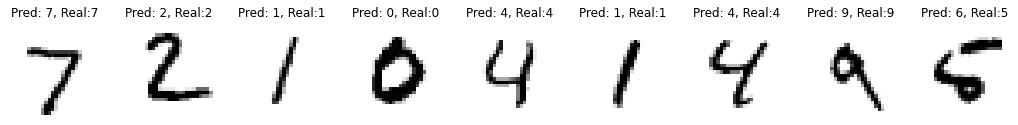

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=9, figsize=(18, 18))
for ax, image, prediction, real in zip(axes, x_test1, predicciones_rbf_10, y_test1):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Pred: {prediction}, Real:{real}')

Vemos que, en este ejemplo, ha acertado la mayoría de imágenes excepto un 5 que ha clasificado como 6. 

#*Dataset* Fashion-MNIST

## **Fashion MNIST**

Fashion-MNIST es un conjunto de datos de las imágenes de los artículos de Zalando (https://www.zalando.es/), que consta de un conjunto de entrenamiento de 60.000 ejemplos y un conjunto de test de 10.000. 

Cada ejemplo es una imagen en escala de grises de 28x28, asociada con una etiqueta con 10 clases. Zalando pretende que Fashion-MNIST sirva como un reemplazo directo del conjunto de datos MNIST original, dedicado a al reconocimiento de dígitos escritos a mano. Comparte el mismo tamaño de imagen y estructura de divisiones de entrenamiento y test. 

**Contenido**

Cada imagen tiene 28 píxeles de alto y 28 de ancho, para un total de 784 píxeles en total. Cada píxel tiene un solo valor de píxel asociado, lo que indica la claridad u oscuridad de ese píxel; los números más altos significan más oscuro. Este valor de píxel es un número entero entre 0 y 255. Los conjuntos de datos de entrenamiento y prueba tienen 785 columnas. 

La primera columna consta de las etiquetas de clase y representa la prenda de vestir. El resto de las columnas contienen los valores de píxeles de la imagen asociada. Cada fila es una imagen separada con sus 784 píxeles.

**Etiquetas**

Cada ejemplo de entrenamiento y prueba se asigna a una de las siguientes etiquetas:

* 0 camiseta / top
* 1 pantalón
* 2 suéter
* 3 vestido
* 4 abrigo
* 5 sandalia
* 6 camiseta
* 7 zapatilla
* 8 bolsa
* 9 bota de tobillo

En primer lugar, importamos los subconjuntos de entrenamiento y *test* desde *TensorFlow*:


In [ ]:
(x_train_2, y_train_2), (x_test_2, y_test_2) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


A continuación, nos valemos de la función `reshape()` para almacenar una única línea (de 28x28=784 columnas) por cada imagen:

In [ ]:
x_train_2 = x_train_2.reshape(60000,-1)
x_test_2 = x_test_2.reshape(10000,-1)

In [ ]:
print(x_train_2.shape)
print(x_test_2.shape)

(60000, 784)
(10000, 784)


A continuación se ha representado una muestra de las categorías contenidas en el *dataset* con sus imágenes correspondientes:

In [ ]:
y_u=pd.DataFrame(y_train_2).drop_duplicates()
X_u=x_train_2[y_u[0].sort_values().index]

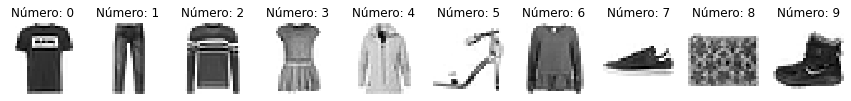

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, label in zip(axes, X_u, y_u[0].sort_values()):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Etiqueta: %i' % label)

Podemos comprobar qué porcentaje del total supone cada dígito:

In [ ]:
pd.Series(y_train_2).value_counts()/60000

9    0.1
8    0.1
7    0.1
6    0.1
5    0.1
4    0.1
3    0.1
2    0.1
1    0.1
0    0.1
dtype: float64

Vemos que es un *dataset* completamente balanceado.

Al igual que para el *dataset* anterior, cada pixel de una imagen puede tomar valores entre 0 y 255, por lo que vamos a proceder a normalizar las cantidades dividiendo por dicha cifra.

In [ ]:
x_train_2.max()

255

In [ ]:
# convert from integers to floats
x_train_2 = x_train_2.astype('float32')
x_test_2 = x_test_2.astype('float32')
# normalize to range 0-1
x_train_2 = x_train_2 / 255.0
x_test_2 = x_test_2 / 255.0

Comprobamos que ahora el valor máximo es 1:

In [ ]:
x_train_2.max()

1.0

Por último, nos quedamos con los 20.000 primeros registros para el subconjunto de entrenamiento y 10.000 para el de *test*:

In [ ]:
n_train=20000
x_train_2n=x_train_2[0:n_train]
y_train_2n=y_train_2[0:n_train]
n_test=10000
x_test_2n=x_test_2[0:n_test]
y_test_2n=y_test_2[0:n_test]

##Modelización

Vamos a repetir los pasos realizados en el anterior *set* de datos, esto es, en primer lugar vamos a comenzar probando a implementar un *kernel* lineal y posteriormente compararemos los resultados con uno *Gaussiano*.

###*Kernel* lineal

Debido al gran impacto que tiene aplicar este *kernel* sobre el *dataset*, únicamente se van a parametrizar valores de $C=1$, $C=10$ y $C=100$ con el objetivo de reducir los tiempos de ejecución. El resto de parámetros serán los definidos por defecto.



In [ ]:
minAcc = 100
maxAcc = 0
rapidoAcc = 0
lentoAcc = 0
mejorTime = 0
peorTime = 0
minTime = 1000000000
maxTime = 0

mejorModelo = SVC()
peorModelo = SVC()
rapidoModelo = SVC()
lentoModelo = SVC()

In [ ]:
kernel = "linear"

for c in (1, 10, 100):
  print("Kernel lineal con C=", c)
  
  timeIni = time()
  modelo = SVC(kernel = kernel, C=c).fit(x_train_2n,y_train_2n)
  print(modelo)
  timeEnd = time()
  timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

  acc_1 = modelo.score(x_train_2n, y_train_2n)
  acc_2 = modelo.score(x_test_2n, y_test_2n)
  print("Precisión train (accuracy): ", acc_1)
  print("Precisión test (accuracy): ", acc_2)
  print("Tiempo entrenamiento: ", timeDiff)

  predicciones = modelo.predict(x_test_2n)
  print("Matriz de confusión:")
  print(confusion_matrix(y_test_2n, predicciones))
  print(classification_report(y_test_2n, predicciones))
  print("---------------------------------------")
  print()

  if (maxAcc < acc_2):
      maxAcc = acc_2
      mejorTime = timeEnd-timeIni
      mejorModelo = modelo

  if (minAcc > acc_2):
      minAcc = acc_2
      peorTime = timeEnd-timeIni
      peorModelo = modelo

  if (timeEnd-timeIni > maxTime):
      lentoAcc = acc_2
      maxTime = timeEnd-timeIni
      lentoModelo = modelo

  if (timeEnd-timeIni < minTime):
      rapidoAcc = acc_2
      minTime = timeEnd-timeIni
      rapidoModelo = modelo

Kernel lineal con C= 1
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Precisión train (accuracy):  0.93265
Precisión test (accuracy):  0.8329
Tiempo entrenamiento:  01:43:942435
Matriz de confusión:
[[820   2  16  38   3   4 104   0  13   0]
 [  9 960   2  21   3   0   3   0   2   0]
 [ 26   5 752  11 118   0  84   0   4   0]
 [ 57  19  23 815  35   0  46   0   5   0]
 [  1   2 141  37 739   0  78   0   2   0]
 [  0   1   0   0   0 924   0  44   3  28]
 [172   4 132  31 106   0 536   0  19   0]
 [  0   0   0   0   0  43   0 929   1  27]
 [ 14   1  11  11   5  10  22   6 920   0]
 [  1   0   0   0   0  18   1  46   0 934]]
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1000
           1       0.97      0.96      0.96      1000
   

En este caso sucede algo similar a la casuística observada para el *kernel* lineal en el *dataset* previo: mientras que la *accuracy* del subconjunto de entrenamiento aumenta con $C$, la del subconjunto de *testing* va disminuyendo. Además, vemos que ahora la precisión global nunca llega a alcanzar un 100%, mientras que los tiempos de ejecución aumentan drásticamente. 

Así, se tiene que al aumentar $C$, aumenta el ajuste del modelo al *set* de entrenamiento pero disminuye ligeramente su capacidad de predicción sobre nuevos subconjuntos de datos. Es decir, estamos observando las consecuencias de un ligero sobreajuste u *overfitting*. Para evitarlo, **seleccionamos $C=1$ como parámetro óptimo**, de manera que no se esté penalizando excesivamente cada error de clasificación del modelo. De todas formas, parece evidente que el *kernel* lineal no es una buena elección para la modelización de este conjunto de datos. 

Si nos fijamos en las matrices de confusión del modelo, vemos que en esta ocasión hay muchas disparidades entre clases, al contrario de lo que ocurría para el *dataset* de dígitos del MNIST. En general, los tres modelos arrojan resultados similares, siendo la clase 6 (camiseta) la que peor funciona y la 1 (pantalón) la que mejor funciona en todos ellos.



### *Kernel* radial o *Gaussiano*

Procedemos a parametrizar una SVM con un *kernel* radial para los valores de $C=1$, $C=10$, $C=100$ y $C=1000$. El resto de parámetros serán los definidos por defecto.

In [ ]:
kernel = "rbf"

for c in (1, 10, 100, 1000):
    print("Kernel Gaussiano con C ", c)
    timeIni = time()
    modelo = SVC(kernel = kernel , C=c).fit(x_train_2n,y_train_2n)
    print(modelo)
    timeEnd = time()
    timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

    acc_1 = modelo.score(x_train_2n, y_train_2n)
    acc_2 = modelo.score(x_test_2n, y_test_2n)
    print("Precisión train (accuracy): ", acc_1)
    print("Precisión test (accuracy): ", acc_2)
    print("Tiempo entrenamiento: ", timeDiff)

    predicciones = modelo.predict(x_test_2n)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test_2n, predicciones))
    print(classification_report(y_test_2n, predicciones))
    print("---------------------------------------")
    print()

    if (maxAcc < acc_2):
      maxAcc = acc_2
      mejorTime = timeEnd-timeIni
      mejorModelo = modelo

    if (minAcc > acc_2):
      minAcc = acc_2
      peorTime = timeEnd-timeIni
      peorModelo = modelo

    if (timeEnd-timeIni > maxTime):
      lentoAcc = acc_2
      maxTime = timeEnd-timeIni
      lentoModelo = modelo

    if (timeEnd-timeIni < minTime):
      rapidoAcc = acc_2
      minTime = timeEnd-timeIni
      rapidoModelo = modelo

Kernel Gaussiano con C  1
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Precisión train (accuracy):  0.90425
Precisión test (accuracy):  0.8639
Tiempo entrenamiento:  01:58:598535
Matriz de confusión:
[[810   0  14  53   3   2 107   0  11   0]
 [  3 955   5  30   3   0   3   0   1   0]
 [ 14   1 790  11 113   0  67   0   4   0]
 [ 23   5  12 887  29   0  41   0   3   0]
 [  0   0  93  33 793   0  77   0   4   0]
 [  0   0   0   1   0 942   0  40   1  16]
 [134   1 112  36  77   0 624   0  16   0]
 [  0   0   0   0   0  31   0 927   0  42]
 [  2   1   1   6   2   4  12   5 967   0]
 [  0   0   0   0   0  15   0  40   1 944]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1000
           1       0.99      0.95      0.97      1000
   



En esta última modelización, observamos un gran salto en la precisión global sobre el subconjunto de entrenamiento al pasar de $C=1$ (90%) a $C=10$ (97%). Asimismo, también aumenta levemente la precisión sobre el subconjunto de *testing*. Se trata, pues, de un claro ejemplo de *underfitting* para valores $C<10$, tal y como se había obtenido en el *dataset* de dígitos del MNIST. De nuevo, para $C=10$ existe un máximo en la *accuracy* (*test*), mientras que para $C>10$ esta vuelve a disminuir ligeramente, es decir, existe cierto *overfitting* para valores superiores a 10.


En general, hemos conseguido aumentar las precisiones con respecto al *kernel* lineal, sobre todo para valores $C>1$. En lo referente a tiempos de ejecución, todos ellos están por debajo de los 2 minutos, siendo $C=1$ el más lento mientras que $C=10$ es el más rápido. Concluimos, por tanto, que este *kernel* parece ser una elección mucho mejor para este subconjunto de datos con el que estamos trabajando con respecto al *kernel* lineal, en particular si **seleccionamos $C=10$**.

Si nos fijamos en las matrices de confusión, vemos que, como era de esperar, las precisiones de todas las categorías han aumentado con respecto al *kernel* lineal. Además, se sigue teniendo que la peor clase es la 6 (camiseta) mientras que la que mejor funciona es la 1 (pantalón) en los 4 modelos planteados.

##Comparativa entre modelos

De entre todos los modelos propuestos para este *dataset*, se procede a realizar un resumen de los resultados obtenidos:

In [ ]:
print("El mejor modelo es: ", mejorModelo.kernel)
print(mejorModelo)
print("Accuracy: ", maxAcc)
print("Tiempo: ", datetime.datetime.fromtimestamp(mejorTime).strftime("%M:%S:%f"))
print()

print("El peor modelo es: ", peorModelo.kernel)
print(peorModelo)
print("Accuracy: ", minAcc)
print("Tiempo: ", datetime.datetime.fromtimestamp(peorTime).strftime("%M:%S:%f"))
print()

print("El modelo más rápido es: ", rapidoModelo.kernel)
print(rapidoModelo)
print("Accuracy: ", rapidoAcc)
print("Tiempo: ", datetime.datetime.fromtimestamp(minTime).strftime("%M:%S:%f"))
print()

print("El modelo más lento es: ", lentoModelo.kernel)
print(lentoModelo)
print("Accuracy: ", lentoAcc)
print("Tiempo: ", datetime.datetime.fromtimestamp(maxTime).strftime("%M:%S:%f"))

El mejor modelo es:  rbf
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:  0.8797
Tiempo:  01:46:487308

El peor modelo es:  linear
SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:  0.8104
Tiempo:  13:57:149670

El modelo más rápido es:  linear
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:  0.8329
Tiempo:  01:43:942435

El modelo más lento es:  linear
SVC(C=1

En la siguiente tabla se recoge una comparación de todos los modelos ejecutados hasta ahora:

|$C$|*Accuracy* lineal (%)|*Accuracy Gaussiano* (%)|Tiempo lineal|Tiempo *Gaussiano*|
|:-----:|:--------:|:-------:|:---------:|:---------:|
|  $1$  |  83.29   |   86.39    | 1min 44s  |1min 59s   | 
|  $10$ |  81.57   |   87.97    | 2min 50s  |1min 46s   |
| $100$ |  81.04   |   87.56    | 13min 57s |1min 47s   |
|$1000$ |  NA      |   87.56    | NA        |1min 47s   |

En general, el *kernel Gaussiano* obtiene mejores resultados en las precisiones globales. De hecho, vemos que el modelo más preciso es el *Gaussiano* con $C=10$ mientras que el más rápido es el lineal con $C=1$. Por el contrario, el *kernel* lineal funciona muy mal para valores altos del parámetro $C$. Estos resultados coinciden con los obtenidos para el *dataset* de dígitos del MNIST. 

En definitiva, el modelo óptimo para este *dataset* es el radial con $C=10$ pues, si bien es ligeramente más lento que el lineal con $C=1$, la diferencia no es muy notable (2s) y la mejora obtenida en la precisión global es significativa (4.5% más).

##Evaluación del modelo

De nuevo, si generamos el modelo más preciso con `kernel='rbf'` y `C=10`:

In [ ]:
modelo_rbf_10_2 = SVC(kernel = "rbf" , C=10).fit(x_train_2n,y_train_2n)
acc_rbf_10_2 = modelo_rbf_10_2.score(x_test_2n, y_test_2n)
predicciones_rbf_10_2 = modelo_rbf_10_2.predict(x_test_2n)

- **Matriz de confusión**

A continuación generamos su matriz de confusión sobre el subconjunto de *test*:

Confusion matrix:



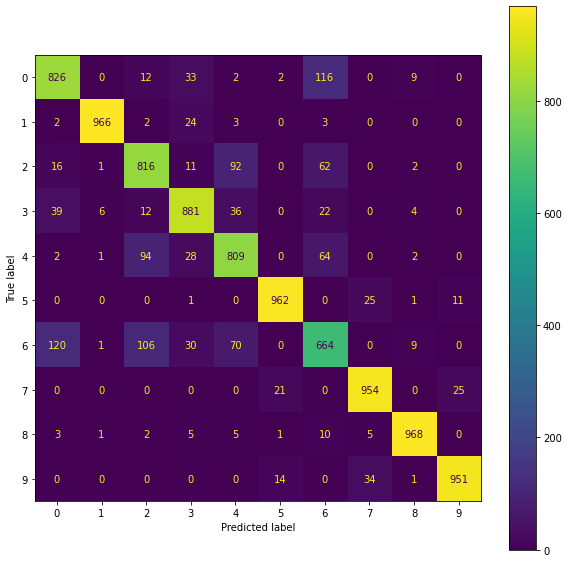

In [ ]:
print(f"Confusion matrix:\n")
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(modelo_rbf_10_2, x_test_2n, y_test_2n, cmap=plt.cm.viridis, ax=ax, values_format = '.0f')
plt.show()

Vemos que, para este *dataset*, hay muchos más elementos fuera de la diagonal con respecto al *dataset* de dígitos como era de esperar pues tanto la *precision* como el *recall* han disminuido en todas las categorías.

En particular, destaca el gran número de falsos positivos y negativos para la etiqueta 6. Si calculamos su *precision* y su *recall*:

$$ Precision_6 =  \frac{TP}{TP+FP} = \frac{664}{116+3+62+22+64+10}= 0.7056$$ 

$$ Recall_6 =  \frac{TP}{TP+FN}=\frac{664}{664+120+1+106+30+70+9}=0.664$$ 

- ***Precision* y *recall***

Si obtenemos estos indicadores para todas las clases (gracias a `classification_report()`):

In [ ]:
print(f"Classification report for classifier {modelo_rbf_10_2}:\n"
      f"{metrics.classification_report(y_test_2n, predicciones_rbf_10_2)}\n")

Classification report for classifier SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.78      0.82      0.80      1000
           3       0.87      0.88      0.88      1000
           4       0.80      0.81      0.80      1000
           5       0.96      0.96      0.96      1000
           6       0.71      0.66      0.68      1000
           7       0.94      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted 

La clase 6 (camiseta) es, con diferencia, la categoría con la que más dificultades está teniendo el algoritmo de clasificación. Para las observaciones erróneas, es decir, aquellas fuera de la diagonal, se tiene que la mayoría de falsos negativos están causados por el hecho de que el algoritmo clasifica las camisetas como 0 (top), 2 (suéter) y 4 (abrigo). Es razonable que la predicción sea mala en estos casos pues son prendas de ropa muy similares. Asimismo, la mayoría de falsos positivos también están originados por esas 3 categorías, las cuáles están confundiéndose con camisetas.

Para el resto de categorías excepto la 6 (camiseta), el modelo tiene un *F1-Score* superior al 80%. Destacan las clases 1 (pantalón), 5 (sandalia), 8 (bolso) y 9 (botín) por sus altos valores tanto del *precision* como del *recall* (>95%). Tiene sentido que estas categorías sean las que mejores predicciones arrojan pues son las más diferentes al resto visualmente.

Por último, podemos representar algunas predicciones del algoritmo:

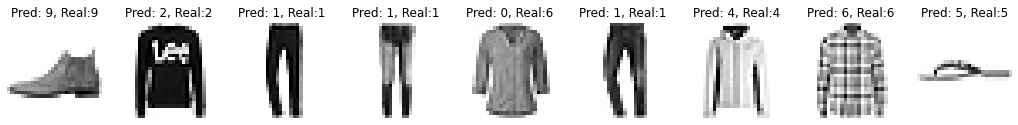

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=9, figsize=(18, 18))
for ax, image, prediction, real in zip(axes, x_test_2n, predicciones_rbf_10_2, y_test_2n):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Pred: {prediction}, Real:{real}')

En este ejemplo, vemos cómo se han clasificado correctamente todas las imágenes excepto una camiseta (6) que ha sido clasificada como "top" (0).

#Conclusiones

A lo largo de la tarea se han implementado varios algoritmos de tipo *Support Vector Machine* sobre dos *datasets* de imágenes mediante la función `SVC`, para la cual se ha tratado de obtener la parametrización más óptima en función del *kernel* (lineal o radial) y del hiperparámetro $C$.

Se han observado comportamientos similares para ambos *datasets*, los cuales contenían 60.000 registros de imágenes 28x28. Para el entrenamiento de cada modelo se han seleccionado las 20.000 primeras instancias de cada conjunto, y posteriormente se han evaluado sobre 10.000 registros del conjunto de *test*.

El modelo óptimo se ha seleccionado teniendo en cuenta que no existiera un sobreajuste al *dataset* de entrenamiento ($C$ demasiado alto) ni una simplificación excesiva o *underfitting* ($C$ excesivamente bajo). En ambos *datasets*, el *kernel* radial con $C=10$ es el que mejores predicciones arroja a la hora de evaluar el modelo, si bien es ligeramente más lento que el *kernel* lineal con $C=1$, opción que elegiríamos si quisiéramos reducir el coste computacional.

En la siguiente tabla se resumen los principales resultados para la precisión (%) sobre el subconjunto de *testing* obtenidos para cada *dataset*:


    

|    *Kernel*                        |MNIST *dataset*|*Fashion*-MNIST|
|-------------------------------------------|:--------:|:-------:|
| **Lineal** - *Accuracy* promedio  |     91.76    |    81.97     | 
| **Radial** - *Accuracy* promedio  |      97.48   |    87.37    |
| **Lineal** - *Accuracy* máxima    |92.57 ($C=1$) |83.29 ($C=1$) | 
| **Radial** - *Accuracy* máxima    |97.67 ($C=10$)|87.97 ($C=10$)| 

Como puede comprobarse, existe una diferencia de aproximadamente un 10% de un *dataset* a otro tanto para la precisión máxima como para el promedio por cada *kernel*. Este hecho se debe a que el segundo *dataset* contiene imágenes que, si bien tienen la misma resolución (28x28), contienen más información. 

Si nos fijamos en las representaciones gráficas realizadas como ejemplo de algunas imágenes de cada conjunto de datos, vemos que mientras que para el *dataset* de dígitos la mayoría de píxeles están en blanco y el resto en negro, para el *dataset* de ropa existen muchos más grises y prendas de ropa similares entre sí. Por tanto, el algoritmo tiene más dificultad a la hora de clasificar la ropa, pues es mucho más difícil de extraer el patrón subyacente de cada categoría. En otras palabras, el segundo *dataset* no es tan fácilmente separable, lo que se traduce en una disminución de la precisión global del modelo.

Asimismo, concluimos que un *kernel* radial parece ser una mejor opción para este tipo de *datasets*, ya que debido a su complejidad y poca separabilidad, el *kernel* lineal tiene más dificultades a la hora de clasificar.